## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Data pre-processing

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "eye-disease",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4217 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [5]:
len(dataset)

132

## Visualization

2024-09-08 16:16:30.636014: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


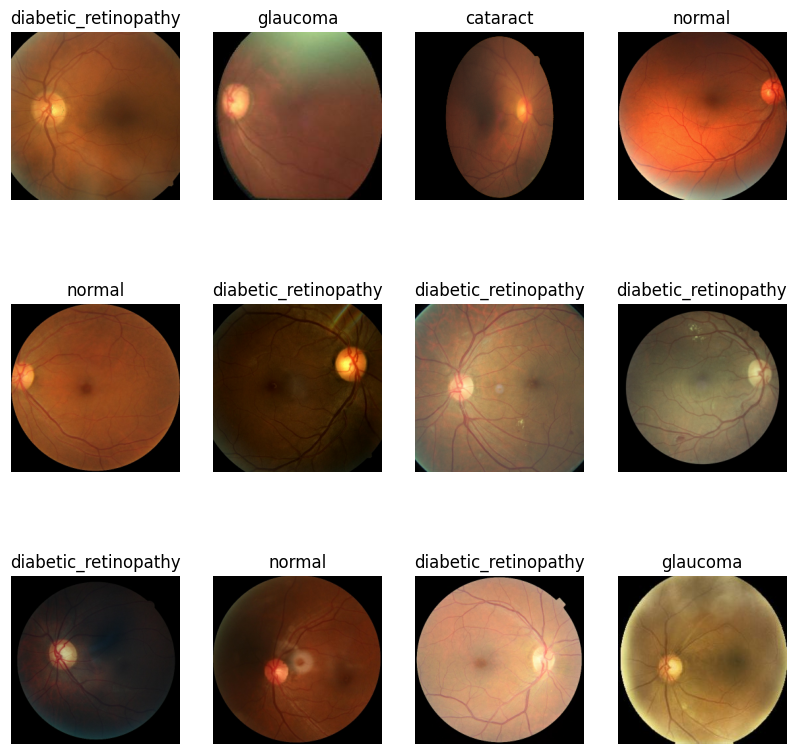

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Dataset Split Criteria - <br>
80% ==> training <br>
10% ==> validation <br>
10% ==> testing <br>

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size  = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size  = int(val_split * ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

13

In [17]:
len(test_ds)

14

In [18]:
trains_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Rescaling and resizing

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


## Model Building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax'),
    
])
model.build(input_shape=input_shape)


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 40s 719ms/step - loss: 1.3328 - accuracy: 0.3455 - val_loss: 1.2142 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 30s 540ms/step - loss: 1.1412 - accuracy: 0.5017 - val_loss: 0.9920 - val_accuracy: 0.5962
Epoch 3/50
54/54 [==============================] - 30s 551ms/step - loss: 0.9613 - accuracy: 0.5984 - val_loss: 0.8024 - val_accuracy: 0.6611
Epoch 4/50
54/54 [==============================] - 31s 558ms/step - loss: 0.8528 - accuracy: 0.6325 - val_loss: 0.9034 - val_accuracy: 0.6322
Epoch 5/50
54/54 [==============================] - 31s 564ms/step - loss: 0.8451 - accuracy: 0.6539 - val_loss: 0.6586 - val_accuracy: 0.6995
Epoch 6/50
54/54 [==============================] - 31s 564ms/step - loss: 0.7555 - accuracy: 0.6916 - val_loss: 0.6132 - val_accuracy: 0.7308
Epoch 7/50
54/54 [==============================] - 32s 571ms/step - loss: 0.7264 - accuracy: 0.6921 - val_loss: 0.6250 - val_accuracy: 0.7404

## Model Evaluation

In [25]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 12s 181ms/step - loss: 0.3436 - accuracy: 0.8685


In [26]:
scores

[0.3435627818107605, 0.8684807419776917]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['accuracy']

[0.3454861044883728,
 0.5017361044883728,
 0.5983796119689941,
 0.6325231194496155,
 0.6539351940155029,
 0.6915509104728699,
 0.6921296119689941,
 0.7297453880310059,
 0.7546296119689941,
 0.7546296119689941,
 0.7615740895271301,
 0.7928240895271301,
 0.7771990895271301,
 0.7818287014961243,
 0.7818287014961243,
 0.7853009104728699,
 0.8032407164573669,
 0.8142361044883728,
 0.8200231194496155,
 0.8206018805503845,
 0.8252314925193787,
 0.8287037014961243,
 0.8263888955116272,
 0.8321759104728699,
 0.8576388955116272,
 0.8524305820465088,
 0.8506944179534912,
 0.8472222089767456,
 0.859375,
 0.8559027910232544,
 0.8767361044883728,
 0.8501157164573669,
 0.8547453880310059,
 0.8692129850387573,
 0.8680555820465088,
 0.8628472089767456,
 0.8576388955116272,
 0.8605324029922485,
 0.8732638955116272,
 0.8755787014961243,
 0.8640046119689941,
 0.8732638955116272,
 0.8744212985038757,
 0.8680555820465088,
 0.8761574029922485,
 0.8703703880310059,
 0.8755787014961243,
 0.8761574029922485,
 0

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



## Accuaracy and Loss Visualization

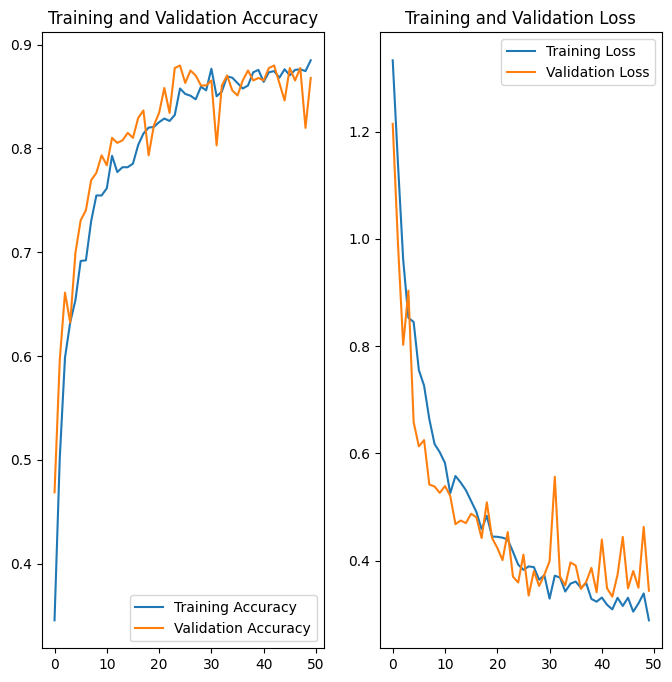

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

first image to predict
first image's actual label: glaucoma
1/1 [==============================] - 0s 145ms/step
predicted label:  glaucoma


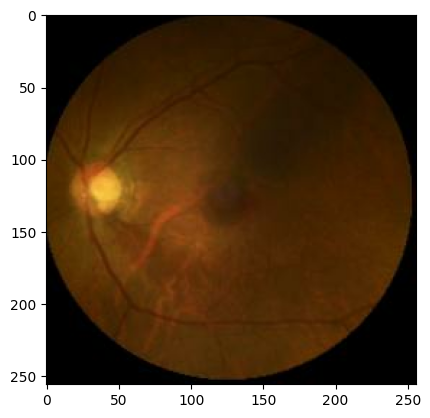

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image =images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Model Prediction with Confidence Scores

1/1 [==============================] - 0s 15ms/step


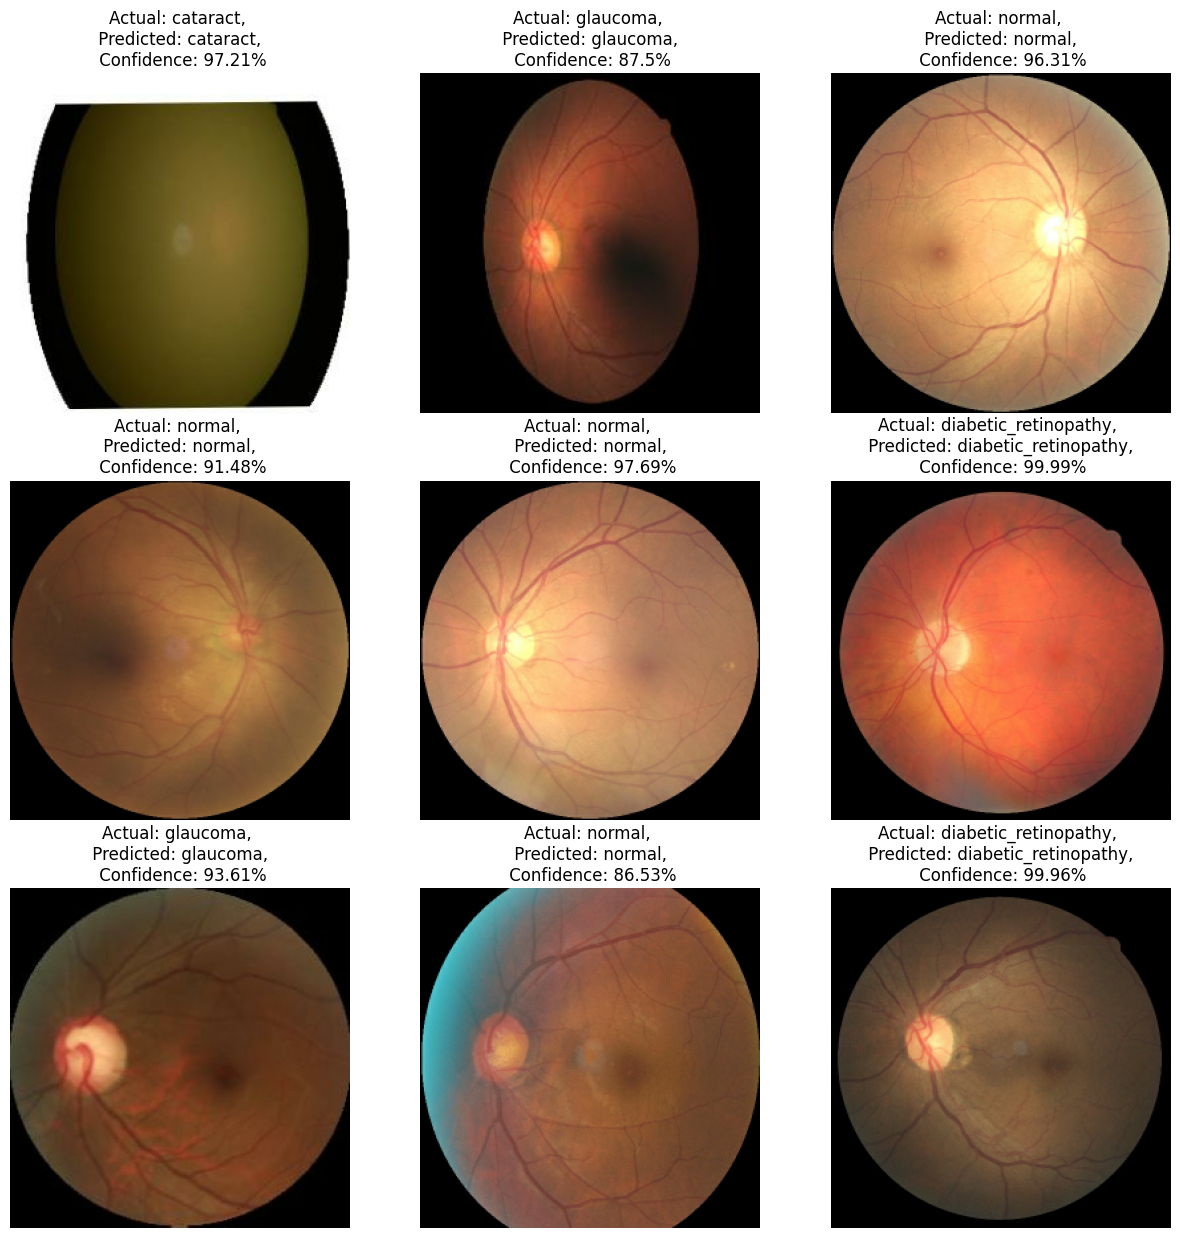

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

## Model Saving and Versioning 

In [36]:
import os
model_version = max([int(i) for i in os.listdir("../model") if i.isdigit()] + [0]) + 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/3/assets


INFO:tensorflow:Assets written to: ../model/3/assets
